In [1]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

___
Enter Team Member Names here (*double click to edit*):

- Name 1: Juliana Antonio
- Name 2: Xiaona Hang
- Name 3: Chuanqi Deng

___

# In Class Assignment Three
In the following assignment you will be asked to fill in python code and derivations for a number of different problems. Please read all instructions carefully and turn in the rendered notebook (or HTML of the rendered notebook)  before the end of class (or right after class). The initial portion of this notebook is given before class and the remainder is given during class. Please answer the initial questions before class, to the best of your ability. Once class has started you may rework your answers as a team for the initial part of the assignment. 

<a id="top"></a>
## Contents
* <a href="#LoadingKDD">Loading KDDCup Data</a>
* <a href="#kdd_eval">KDDCup Evaluation and Cross Validation</a>
* <a href="#data_snooping">More Cross Validation</a>
* <a href="#stats">Statistical Comparison</a>

**Before coming to class**, please make sure you have the latest version of `scikit-learn`. This notebook was created for version 0.18 and higher. 

________________________________________________________________________________________________________

<a id="LoadingKDD"></a>
<a href="#top">Back to Top</a>
## Loading KDDCup Data

Please run the following code to read in the "KDD Cup" dataset from sklearn's data loading module. It consists of examples of different simulated attacks for the 1998 DARPA Intrusion Detection System (IDS). 

This will load the data into the variable `ds`. `ds` is a `bunch` object with fields like `ds.data` and `ds.target`. The field `ds.data` is a numpy matrix of the continuous features in the dataset. **The object is not a pandas dataframe. It is a numpy matrix.** Each row is a set of observed instances, each column is a different feature. It also has a field called `ds.target` that is an integer value we are trying to predict (i.e., a specific integer represents a specific person). Each entry in `ds.target` is a label for each row of the `ds.data` matrix. 

In [1]:
# fetch the dataset
from sklearn.datasets import  fetch_kddcup99
from sklearn import __version__ as sklearn_version

print('Sklearn Version:',sklearn_version)
ds =  fetch_kddcup99(subset='http')

Sklearn Version: 1.0.2


In [3]:
# print(ds)

In [2]:
import numpy as np
# get some of the specifics of the dataset
X = ds.data
y = np.array(ds.target != b'normal.')
y = y.astype(int)

n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 58725
n_features: 3
n_classes: 2


___
**Question 1:** How many instances are in the binary classification problem loaded above? How many instances are in each class? **Plot a pie chart or bar chart of the number of instances in each of the classes.**

*Enter you answer here*

 - There are 58,725 instances in the binary classification problem.
 - There are 2209 instances in the in the Abnormal class, and 56516 instances in the Normal class.
 

Number of instances in each class:
 	 Abnormal instances:2209, Normal instances: 56516


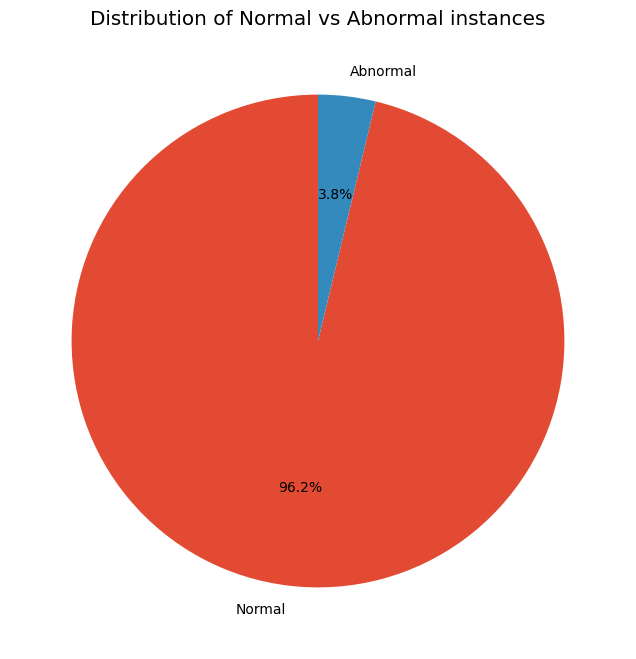

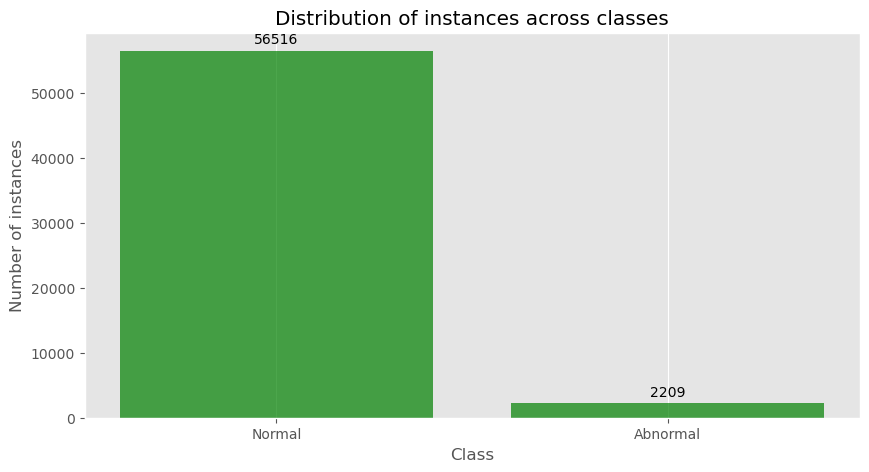

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


#=== Fill in code below========

# you might be interested in the functions:
#     np.bincount
#     plt.hist

class_counts = np.bincount(y)
y_normal = class_counts[0]
y_abnormal = class_counts[1]

print(f"Number of instances in each class:\n \t Abnormal instances:{y_abnormal}, Normal instances: {y_normal}")

# A pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=['Normal', 'Abnormal'], autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Normal vs Abnormal instances")
plt.show()

# A bar chart
counts = [y_normal, y_abnormal]
labels = ['Normal', 'Abnormal']

plt.figure(figsize=[10,5])
# plt.hist(labels, weights=counts, bins=np.arange(-0.5, 2, 1), rwidth=0.8, color='green', alpha=0.7 )
bars = plt.bar(labels, counts, color='green', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Distribution of instances across classes')
plt.grid(axis='y')

# Adding the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()


<a id="kdd_eval"></a>
<a href="#top">Back to Top</a>
## KDDCup Evaluation and Cross Validation
Look at the following code that trains a model using 10-fold cross validation. You can also run this code to see the outputs. Then answer the question below it. 

You might also be interested in the following graphic: 
- https://en.wikipedia.org/wiki/Precision_and_recall#/media/File:Precisionrecall.svg

And the following:
$$ Precision = \frac{TP}{TP+FP} $$

and

$$ Recall = \frac{TP}{TP+FN} $$

and 

$$ F_1 = 2\cdot\frac{Precision\cdot Recall}{Precision + Recall} $$

and a new score that you might like to look at:

$$ F_{\beta} = (1+\beta^2)\cdot\frac{Precision\cdot Recall}{\beta^2\cdot Precision + Recall} $$

(0.9894891008174387, 1.0)

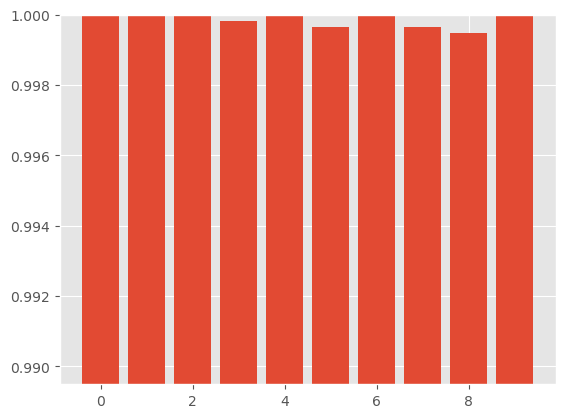

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression

# select model
clf = LogisticRegression()
#select cross validation
cv = KFold(n_splits=10)
# select evaluation criteria
my_scorer = make_scorer(accuracy_score)
# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

____
**Question 2** Is the code above a proper separation of training and testing sets for the given dataset (i.e., using KFold)? Why or why not? 

*Enter you answer here*

No.

The given dataset is with a significant imbalance between classes (Abnormal instances:2209, Normal instances: 56516).  When using KFold, it can lead to flods that don't represent the overall distribution of the classes, leading to misleading performace estimates.

The proper separation for training and testing sets with imbalanced datasets is better achieved using **StratifiedKFold**.
___

**Question 3:** Is the evaluation metric chosen in the above code appropriate for the dataset (i.e., using accuracy)? Why or Why not?

*Enter you answer here*

No.

Using accuracy as an evaluation metric is not appropriate for datasets with a significant class imbalance. For dataset where one class significantly outnumbers the other, a naive model that always predicts the dominant class will achieve the accuracy of the domimant class.

The dataset is highly skewed towards 'Normal' instances.This means a model could trivially predict 'Normal' for all instances and still achieve high accuracy due to the imbalance, without truly capturing the performance of the model, especially in correctly predicting 'Abnormal' instances which are of likely higher interest.


Metrics like precision, recall, F1 score are more informative for imbalanced datesets because they provide a better insight into how well the model is predicting each class.

In our case, minimizing False Negatives is the most crucial factor, as we want our model to perform with as few False Negatives as possible. Simultaneously, achieving a high True Positive rate is always a good indicator of a well-performing model. For our study, we will not prioritize Precision since it does not account for False Negatives. Instead, the F1 score is highly recommended as the appropriate evaluation criterion for our situation.

**Exercise 1:** If the code above is not a proper separation of the train or does not use the proper evaluation criteria, fix the code in the block below to use appropriate train/test separation and appropriate evaluation criterion (criteria). **Mark changes in the code with comments.**

(0.9808675799086757, 1.0)

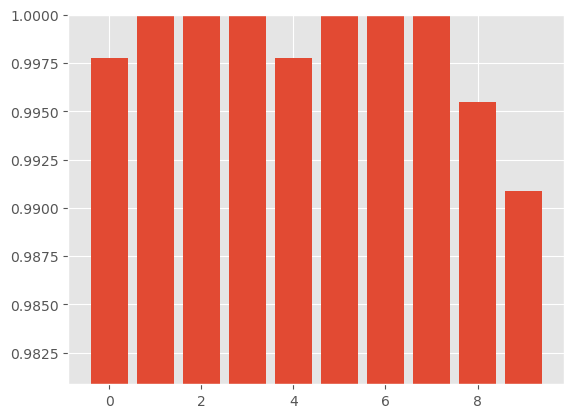

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
# these imports above might help you

#=====Write your code below here=================
# select model
clf = LogisticRegression()

#select cross validation method
cv = StratifiedKFold(n_splits=10)  # Changed to StratifiedKFold

# select evaluation criteria
my_scorer = make_scorer(f1_score) # Changed to F1 Score for imbalanced issue

# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )

# Plot the evaluation criteria per fold
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])
# plt.show() # Added to visualize the plot

____
**Question 4**: Does the learning algorithm perform well based on the evaluation criteria? Why or why not, based on the way the system will be used?


*Enter you answer here (double click to edit)*

No.


In our dataset, having even a single False Negative is very bad. An evaluation result of less than 100% indicates the presence of both false negatives and false positives.

___


<a id="data_snooping"></a>
<a href="#top">Back to Top</a>

## More Cross Validation

**Exercise 2:** Does the code below contain any errors in the implementation of the cross validation? If so, explain the errors in the space provided below and then fix the code below so that there are no longer any errors in the cross validation.


*Explain any cross validation errors here (double click to edit)*

Yes. 

The errors of the code is that PCA is performed just once on the entire dataset before cross-validation. It doesn't incorporate the PCA as part of a pipeline to avoid data leakage during the implementation of the cross-validate process. Futhermore, it should use StratifiedKFold which is essential for imbalanced datasets.

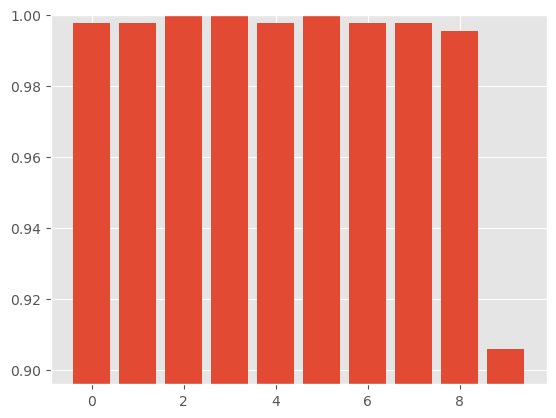

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

# #======If there are errors, fix them below======
# n_components = 1
# pca = PCA(n_components=n_components)
# Xpca = pca.fit_transform(X)

# clf = Pipeline([('scl',StandardScaler()),
#                 ('clf',LogisticRegression())])

# per_fold_eval_criteria = cross_val_score(estimator=clf,
#                                     X=Xpca,
#                                     y=y,
#                                     cv=cv,
#                                     scoring=my_scorer
#                                    )

# plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
# plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])


# =====fixed code======


cv = StratifiedKFold(n_splits=10)

# Create a pipeline with PCA and LogisticRegression
clf = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=1, random_state=1)),
    ('clf', LogisticRegression())
])

# Use F1 score as the scoring method
my_scorer = make_scorer(f1_score)

# Run model training and cross-validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                         X=X,
                                         y=y,
                                         cv=cv,
                                         scoring=my_scorer)


# Plot the evaluation criteria per fold
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

___

# Circumstances Change
For this question, the circumstances for the DARPA KDD99 cup are changed in the following way:
- When the model for detecting attacks is deployed, we now think that it will often need to be retrained because new attacks will emerge.
 - DARPA anticipates that there will be a handful of different style attacks on their systems that have never been seen before. To detect these new attacks, they are employing programmers and analysts to find them manually every day. 
 - DARPA believes the perpetrators of these new attacks are more sophisticated, so finding the new attacks will take priority over detecting the older, known attacks. 
- DARPA wants to use your learning algorithm for detecting only these new attacks. However, they tell you that the amount of training data for the new attacks will be extremely small. That is, the analysts can only identify a handful of new style attacks each day (so you will only have about 3-5 examples of the attacks for training).
- **DARPA asks you: Do you think its a good idea to employ retraining your model each day to find these new attacks?** They need an answer in the next 20 minutes.  

**Question 5**: How would you change the method of cross validation to answer this question from DARPA? That is, how can you change your cross validation method to better mirror how your system will be used and deployed by DARPA when there are only 3-5 attack examples available for training? *Note: you do not have access to these new training examples. You need to change you cross validation method with the existing data to answer this question.* 

*Enter your answer here (double click)*

Since DARPA anticipates only a few examples of 3-5 new attacks to train on each day, we could use a form of cross-validation method to mirror this cenario. A particularly suitable method is likely to choose a significantly smaller traning set of examples of older attacks, and then test on a relatively larger dataset. For this approach, we only have a few positive examples to use while training.

Using StratifiedShuffleSplit with a very small train_size could help simulate the scenario where the model has to learn from very few examples of a particular class as the Extreme Case Cross-Validation. In this approach, **train_size** is set to a very small percentage, reflecting the 3-5 examples of new attacks they expect to get daily. This setup would better mirror how the system will be used and deployed by DARPA.

Ideally, we would build a learning curve from the current data to better understand minimum amount of data required for the reliable detection of each new attack.

In [9]:
#plotting function for use in next question
# takes input 'test_scores', axis labels, and an x-axis label
%matplotlib inline
def plot_filled(test_scores,train_x_axis, xlabel=''):
    
    test_mean = np.percentile(test_scores,50, axis=1)
    test_max = np.percentile(test_scores,95, axis=1) 
    test_min = np.percentile(test_scores,5, axis=1) 

    plt.plot(train_x_axis, test_mean,
             color='blue', linestyle='--',
             marker='s', markersize=5,
             label='validation set')

    plt.fill_between(train_x_axis,
                     test_min,
                     test_max,
                     alpha=0.15, color='blue')

    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel('Evaluation Criterion')
    plt.legend(loc='lower right')
    plt.tight_layout()

___
DARPA is also concerned about how much training data they will need from the analysts in order to have a high performing model. They would like to use the current dataset to help answer that question. The code below is written for you to help answer DARPA's question about how many examples will be needed for training. Examine the code and the output (please rerun with your evaluation criteria), then answer the following question:

**Question 6**: Based on the analysis graphed below, how many positive examples are required to have a good tradeoff between bias and variance for the given evaluation criteria? Why? *Note: the x-axis really is a percentage, so the value 0.1 is actually 0.1%.*

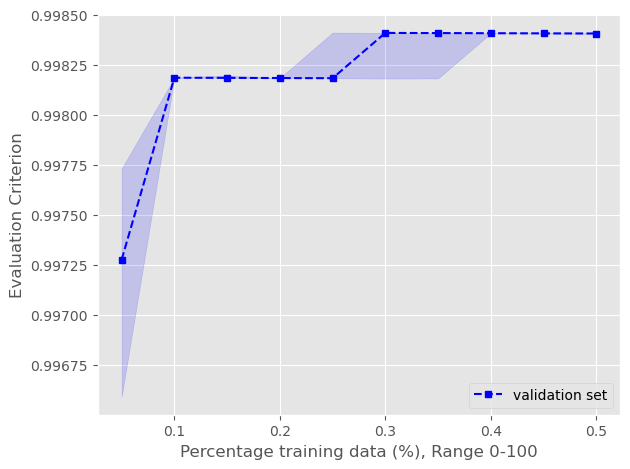

In [10]:
clf = LogisticRegression()

test_scores = []
train_sizes=np.linspace(5e-4,5e-3,10)

for size in train_sizes:
    cv = StratifiedShuffleSplit(n_splits=100,
                                train_size = size,
                                test_size = 1-size,
                               )
    test_scores.append(cross_val_score(estimator=clf,X=X,y=y,cv=cv,scoring=my_scorer))

plot_filled(np.array(test_scores), train_sizes*100, 'Percentage training data (%), Range 0-100')

___

*Enter you answer here*

0.3% of positive examples.

It seems that around 0.3% of the total data might be optimal to have a good tradeoff between bias and variance.

Initially performance increased significantly from 0 to 0.1% training data then stayed same, and second performance increased from 0.25 to 0.3%. This means initially, a smaller set of examples can be used to quickly ramp up detection capabilities

Beyond 0.3%, the performance level seems to stabilize, indicating that the model has likely reached a point of diminishing returns where additional data does not significantly contribute to improving performace. It makes 0.3% a good trade-off between training data volume and molde efficiency.
___

___
<a id="stats"></a>
<a href="#top">Back to Top</a>

# Statistical Comparison
Now lets create a few different models and see if any of them have statistically better performances. 

We are creating three different classifiers below to compare to one another. For creating different training and testing splits, we are using stratified shuffle splits on the datasets. 



In [11]:
clf1 = LogisticRegression(C=100)
clf2 = LogisticRegression(C=1)
clf3 = LogisticRegression(C=0.1)

train_size = 0.003 # small training size
cv = StratifiedShuffleSplit(n_splits=10,train_size=train_size,test_size=1-train_size)

evals1 = cross_val_score(estimator=clf1,X=X,y=y,scoring=my_scorer,cv=cv)
evals2 = cross_val_score(estimator=clf2,X=X,y=y,scoring=my_scorer,cv=cv)
evals3 = cross_val_score(estimator=clf3,X=X,y=y,scoring=my_scorer,cv=cv)

**Question 7**: Given the code above, what statistical test is more appropriate for selecting confidence intervals, and **why**? Your options are:
- **A**: approximating the evaluation criterion as a binomial distribution and bounding by the variance (the first option we used in the flipped lecture video)
- **B**: approximating the bounds using the folds of the cross validation to get mean and variance (the second option we used in the flipped lecture video)
- **C**: Either are acceptable statistical tests for obtaining confidence intervals

**B**.

The reason that I think B is correct is that it involves calculating mean and variance from the folds of cross-validation which makes it less dependent on the data following a strict binomial distribution. This approach is based on sample means rather than propportions. Futhermore, theoretically, the binomial distribution requires that the data sizes are large enough, which is not suitable when train_size is set to a very small percentage. Such as in our case with DARPA, this setting reflectc the 3-5 examples of new attack expected daily in real-world scenarios*
___

___
**Final Exercise:** With 95% confidence, perform the statistical test that you selected above. Is any model or set of models statistically the best performer(s)? Or can we not say if the models are different with greater than 95% confidence?

If you chose option A, use a multiplier of Z=1.96. The number of instances used in testing can be calculated from the variable `train_size`.

If you chose option B, use a multiplier of t=2.26 and k=10.

In [13]:
#===================================================
# Enter your code below

# Hypothetical mean and std for each model's F1 score from cross-validation
mean1, std1 = np.mean(evals1), np.std(evals1, ddof=1)
mean2, std2 = np.mean(evals2), np.std(evals2, ddof=1)
mean3, std3 = np.mean(evals3), np.std(evals3, ddof=1)


# Number of folds
k = 10
# t-score for 95% confidence with 9 degrees of freedom
t = 2.26

# Compute 95% confidence intervals
ci1 = (mean1 - t * (std1 / np.sqrt(k)), mean1 + t * (std1 / np.sqrt(k)))
ci2 = (mean2 - t * (std2 / np.sqrt(k)), mean2 + t * (std2 / np.sqrt(k)))
ci3 = (mean3 - t * (std3 / np.sqrt(k)), mean3 + t * (std3 / np.sqrt(k)))

print(f'Model 1 95% CI: {ci1}')
print(f'Model 2 95% CI: {ci2}')
print(f'Model 3 95% CI: {ci3}')

# print('Model ??? has statistically the best XXX with 95% confidence')
#===================================================

Model 1 95% CI: (0.9981818181818182, 0.9981818181818184)
Model 2 95% CI: (0.9761699407244904, 1.007003085692794)
Model 3 95% CI: (0.9963104910056955, 0.9968082960908207)


Between Model 1 and Model 2: We cannot definitively declare a winner because their confidence intervals overlap. However, Model 1 shows potential for higher performance.

Between Model 1 and Model 3, and Model 2 and Model 3: Model 1 and Model 2 both outperform Model 3 significantly, as indicated by the non-overlapping confidence intervals.

Thus, we can conclude that Model 3 is statistically the least performing among the three.

________________________________________________________________________________________________________

That's all! Please **save (make sure you saved!!!) and upload your rendered notebook** and please include **team member names** in the notebook submission.